In [2]:
import numpy as np
seed = 42069
np.random.seed(seed)
import pandas as pd
from matplotlib import pyplot as plt
import arviz
import pystan
from scipy import sparse, stats
from typing import Iterable, Union, Callable
from sklearn.model_selection import train_test_split, ParameterGrid
import altair as alt
from time import time, sleep
from tqdm import tqdm
from multiprocessing import Pool
import pickle
import re

# Own files
import utils 
import StanClasses

# Load and preprocess data

The data we have is essentially a matrix, where the each row correspond to a person, and each column correspond to a movie. However, the matrix is very sparse and thus data is stored in sparse format (i.e. specified with indices and the corresponding values). 

In [2]:
# Define constants
DATA_DIR = 'ml-100k'

In [3]:
df, _, _ = utils.get_ml100k_data(DATA_DIR, subsample_top_users=250, subsample_top_items=250)
df[['user_id', 'item_id']] -= 1

# We are not going to use timestamp, therefore drop it
df.drop('timestamp', axis='columns', inplace=True)

The user ids and item (movie) ids are essentially integer ranges, starting from and 1 to the number of users and items respectively. We don't have the all the unique ids when subsampling users and movies. It becomes problematic ... TODO: Write this

In [4]:
def column_relabler(df: pd.DataFrame, column: str):
    uniques = pd.value_counts(df[column], sort=False).index.values
    n_uniques = len(uniques)

    num2id = {num_:id_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    id2num = {id_:num_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    
    df[column] = df[column].map(id2num)
    return id2num, num2id

df_num = df.copy()
user2num, num2user = column_relabler(df_num, 'user_id')
item2num, num2item = column_relabler(df_num, 'item_id')

# p, q represents shape of the matrix as if it was dense
p, q = len(user2num), len(item2num)

In [5]:
len(df_num)/(p*q)

0.49744

In [6]:
df_train, df_val = train_test_split(df_num, test_size=0.1, random_state=seed)

In [7]:
print(f'''Dataframe dimensions:
    df_train: {df_train.shape}
    df_val: {df_val.shape}
    ''')

Dataframe dimensions:
    df_train: (27981, 3)
    df_val: (3109, 3)
    


# Matrix Factorization 
Want to factorize the dense matrix $X_{n\times m} \approx U_{n\times k}V_{k\times m}$, where the subscripts denotes matrix shapes. The $k$ dimension denotes the user specified embedding dimension. We use different probabilistic models for the components. 


## Model 1: Normal
Not as simple as the simple model above, this is the analogous to the "regular" way when doing regression.

$$ U_{ij} \sim N(\mu_U, \sigma_U) $$
$$ V_{ij} \sim N(\mu_V, \sigma_V) $$
$$ X_{ij}\sim N((UV_{ij}), \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$

User defined variables:
$\mu_U, \sigma_U, \mu_V, \sigma_V, a_\beta, b_\beta$

## Model 2: Non-negative Matrix Factorization

$$ U_{ij}\sim Gamma(a_U, b_U) $$
$$ V_{ij}\sim Gamma(a_V, b_V) $$
$$ X_{ij}\sim Normal((UV)_{ij}, \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$

User defined variables:
$a_U, b_U, a_V, b_V, a_\beta, b_\beta$

## Model 3: ARD

$$ U_{ij} \sim N(\mu_U, \alpha_j) $$
$$ V_{ij} \sim N(\mu_V, \alpha_j) $$
$$ X_{ij}\sim N((UV)_{ij}, \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$
$$ \alpha_{j} \sim Gamma(a_\alpha, b_\alpha) $$

User defined variables:
$\mu_U, \mu_V, a_\alpha, b_\alpha, a_\beta, b_\beta$

In [8]:
models = [
    StanClasses.NormalFactorizer,
    StanClasses.NonNegativeFactorizer,
    StanClasses.ARD_Factorizer
]

init_kwargs = {'n_components':[3,5,10,15,20]}
static_kwargs = {'chains':1, 'iter':1200, 'control':{'max_treedepth':15}}

t0 = time()
# hist = utils.fit_and_evaluate_models(
#     models=models,
#     X_train=df_train,
#     X_val=df_val,
#     candidate_kwargs=init_kwargs,
#     static_kwargs=static_kwargs
# )
evaltime = time()-t0

In [67]:
df_hist = pd.read_pickle('histpickle_withmodels5.pkl')
df_hist.sort_values('val_mae', inplace=True)

In [68]:
df_hist

,model,params,fit_time,train_mae,val_mae
11,<StanClasses.ARD_Factorizer object at 0x7f44b6...,{'n_components': 3},4748.817058,0.650973,0.682219
4,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 3},2111.056670,0.649880,0.682658
8,<StanClasses.NormalFactorizer object at 0x7f44...,{'n_components': 3},3204.854954,0.648843,0.682682
13,<StanClasses.ARD_Factorizer object at 0x7f44b7...,{'n_components': 4},5602.443820,0.641505,0.683162
3,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 2},2071.670998,0.663008,0.684316
10,<StanClasses.ARD_Factorizer object at 0x7f44b6...,{'n_components': 2},4142.784668,0.663512,0.684462
2,<StanClasses.NormalFactorizer object at 0x7f44...,{'n_components': 2},1749.650968,0.662816,0.685046
7,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 4},2727.420982,0.640629,0.686005
14,<StanClasses.ARD_Factorizer object at 0x7f44b6...,{'n_components': 5},5765.450424,0.632650,0.687617
9,<StanClasses.NormalFactorizer object at 0x7f44...,{'n_components': 4},3805.049401,0.638381,0.689962


In [69]:
best_model = df_hist['model'].values[0]
best_params = df_hist['params'].values[0].copy()

In [70]:
print(best_model)
print(best_params)

{'n_components': 3}


In [78]:
df_latex.sort_values('val_mae')

,model,params,fit_time,train_mae,val_mae
11,ARD_Factorizer,3,4748.817058,0.650973,0.682219
4,NonNegativeFactorizer,3,2111.056670,0.649880,0.682658
8,NormalFactorizer,3,3204.854954,0.648843,0.682682
13,ARD_Factorizer,4,5602.443820,0.641505,0.683162
3,NonNegativeFactorizer,2,2071.670998,0.663008,0.684316
10,ARD_Factorizer,2,4142.784668,0.663512,0.684462
2,NormalFactorizer,2,1749.650968,0.662816,0.685046
7,NonNegativeFactorizer,4,2727.420982,0.640629,0.686005
14,ARD_Factorizer,5,5765.450424,0.632650,0.687617
9,NormalFactorizer,4,3805.049401,0.638381,0.689962


In [144]:
df_latex = df_hist.copy()
df_latex['params'] = df_latex['model'].apply(lambda x: x.n_components)
df_latex.rename(columns=
    {'params':'k', 'fit_time':'train time (seconds)', 'train_mae':'train MAE', 'val_mae':'val MAE'},
    inplace=True
)
df_latex['model'] = df_latex['model'].apply(lambda x: type(x).__name__)
df_latex['model'] = df_latex['model'].map(
    {'ARD_Factorizer':'ARD',
     'NonNegativeFactorizer':'Non-negative',
     'NormalFactorizer':'Normal'}
)
print(df_latex.set_index(pd.Series(range(1,16))).to_latex(float_format=lambda x: f'{x:.4f}'))

\begin{tabular}{llrrrr}
\toprule
{} &         model &  k &  train time (seconds) &  train MAE &  val MAE \\
\midrule
1  &           ARD &  3 &             4748.8171 &     0.6510 &   0.6822 \\
2  &  Non-negative &  3 &             2111.0567 &     0.6499 &   0.6827 \\
3  &        Normal &  3 &             3204.8550 &     0.6488 &   0.6827 \\
4  &           ARD &  4 &             5602.4438 &     0.6415 &   0.6832 \\
5  &  Non-negative &  2 &             2071.6710 &     0.6630 &   0.6843 \\
6  &           ARD &  2 &             4142.7847 &     0.6635 &   0.6845 \\
7  &        Normal &  2 &             1749.6510 &     0.6628 &   0.6850 \\
8  &  Non-negative &  4 &             2727.4210 &     0.6406 &   0.6860 \\
9  &           ARD &  5 &             5765.4504 &     0.6327 &   0.6876 \\
10 &        Normal &  4 &             3805.0494 &     0.6384 &   0.6900 \\
11 &  Non-negative &  5 &             2528.1382 &     0.6321 &   0.6938 \\
12 &        Normal &  5 &             5514.9162 &     0.62

In [146]:
hist_check_rhat = {'model':[], 'k':[], 'Rhat min':[], 'Rhat max':[], 'Rhat mean':[], 'Rhat std':[]}
hist_check_neff = {'model':[], 'k':[], 'Neff min':[], 'Neff max':[], 'Neff mean':[], 'Neff std':[]}

for model in tqdm(df_hist['model']):
    summary = model.stanfit.summary()
    summary = summary['summary']
    hist_check_rhat['model'].append(type(model).__name__)
    hist_check_rhat['k'].append(model.n_components)
    hist_check_rhat['Rhat min'].append(summary[:,-1].min())
    hist_check_rhat['Rhat max'].append(summary[:,-1].max())
    hist_check_rhat['Rhat mean'].append(summary[:,-1].mean())
    hist_check_rhat['Rhat std'].append(summary[:,-1].std())
    
    hist_check_neff['model'].append(type(model).__name__)
    hist_check_neff['k'].append(model.n_components)
    hist_check_neff['Neff min'].append(summary[:,-2].min())
    hist_check_neff['Neff max'].append(summary[:,-2].max())
    hist_check_neff['Neff mean'].append(summary[:,-2].mean())
    hist_check_neff['Neff std'].append(summary[:,-2].std())

100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


In [153]:
df_rhat = pd.DataFrame(hist_check_rhat)
df_neff = pd.DataFrame(hist_check_neff)

In [154]:
# df_rhat['model'] = df_rhat['model'].apply(lambda x: type(x).__name__)
df_rhat['model'] = df_rhat['model'].map(
    {'ARD_Factorizer':'ARD',
     'NonNegativeFactorizer':'Non-negative',
     'NormalFactorizer':'Normal'}
)
print(df_rhat.set_index(pd.Series(range(1,16))).to_latex(float_format=lambda x: f'{x:.4f}'))

\begin{tabular}{llrrrrr}
\toprule
{} &         model &  k &  Rhat min &  Rhat max &  Rhat mean &  Rhat std \\
\midrule
1  &           ARD &  3 &    0.9990 &    1.3138 &     1.0411 &    0.0887 \\
2  &  Non-negative &  3 &    0.9990 &    1.0338 &     1.0032 &    0.0055 \\
3  &        Normal &  3 &    0.9990 &    2.1189 &     1.2102 &    0.2135 \\
4  &           ARD &  4 &    0.9990 &    1.3835 &     1.0594 &    0.0971 \\
5  &  Non-negative &  2 &    0.9990 &    1.0250 &     1.0026 &    0.0044 \\
6  &           ARD &  2 &    0.9990 &    1.2645 &     1.0478 &    0.0788 \\
7  &        Normal &  2 &    0.9990 &    1.3543 &     1.0640 &    0.0827 \\
8  &  Non-negative &  4 &    0.9990 &    1.0730 &     1.0052 &    0.0092 \\
9  &           ARD &  5 &    0.9990 &    2.2013 &     1.1479 &    0.2843 \\
10 &        Normal &  4 &    0.9990 &    2.4649 &     1.3759 &    0.3153 \\
11 &  Non-negative &  5 &    0.9990 &    1.1202 &     1.0072 &    0.0126 \\
12 &        Normal &  5 &    0.9990 &    1.95

In [155]:
# df_neff['model'] = df_neff['model'].apply(lambda x: type(x).__name__)
df_neff['model'] = df_neff['model'].map(
    {'ARD_Factorizer':'ARD',
     'NonNegativeFactorizer':'Non-negative',
     'NormalFactorizer':'Normal'}
)
print(df_neff.set_index(pd.Series(range(1,16))).to_latex(float_format=lambda x: f'{x:.4f}'))

\begin{tabular}{llrrrrr}
\toprule
{} &         model &  k &  Neff min &  Neff max &  Neff mean &  Neff std \\
\midrule
1  &           ARD &  3 &    4.8574 & 1127.6726 &   275.7620 &  231.6963 \\
2  &  Non-negative &  3 &   40.4421 & 1677.8139 &   318.3954 &  223.1981 \\
3  &        Normal &  3 &    3.4360 & 1020.3357 &    10.5009 &   28.1623 \\
4  &           ARD &  4 &    4.8997 & 1571.0058 &   220.2744 &  272.0015 \\
5  &  Non-negative &  2 &   33.8124 & 1403.8710 &   234.1758 &  191.7673 \\
6  &           ARD &  2 &    5.5987 & 1657.3678 &   297.9770 &  320.3376 \\
7  &        Normal &  2 &    3.9082 & 1127.2144 &    10.0871 &   37.3944 \\
8  &  Non-negative &  4 &   16.0936 & 1799.1824 &   187.5072 &  157.2839 \\
9  &           ARD &  5 &    2.9357 & 1231.9205 &   136.8569 &  228.5099 \\
10 &        Normal &  4 &    2.7750 & 1068.2205 &     8.1337 &   25.1019 \\
11 &  Non-negative &  5 &   35.9622 & 1523.1771 &   268.6275 &  162.7551 \\
12 &        Normal &  5 &    3.3734 &  894.02

In [16]:
best_params.update(static_kwargs)
final_model = type(best_model)(**best_params)

In [17]:
df_full, _, _ = utils.get_ml100k_data(DATA_DIR)
df_full[['user_id', 'item_id']] -= 1

# We are not going to use timestamp, therefore drop it
df_full.drop('timestamp', axis='columns', inplace=True)

df_full_train, df_test = train_test_split(df_full, test_size=0.05, random_state=seed)

In [18]:
# final_model.fit(df_full_train)

In [19]:
with open('final_dict3.pkl', 'rb') as f:
    final_dict = pickle.load(f)

In [20]:
final_dict

{'model': <StanClasses.ARD_Factorizer at 0x7ff21f7cbe48>,
 'params': {'n_components': 10,
  'chains': 1,
  'iter': 1000,
  'control': {'max_treedepth': 15}},
 'fit_time': 77645.62998747826,
 'train_mae': 0.6267519055847237,
 'test_mae': 0.7625644897334257}

In [21]:
df_hist.columns

Index(['model', 'params', 'fit_time', 'train_mae', 'val_mae'], dtype='object')

In [22]:
# final_model_object, fit_time, train_mae, test_mae =\
#     utils.fit_and_evaluate((type(best_model), best_params, df_full_train, df_test))

# hist2 = {
#     'model':final_model_object,
#     'params':best_params,
#     'fit_time':fit_time,
#     'train_mae':train_mae,
#     'test_mae':test_mae
# }

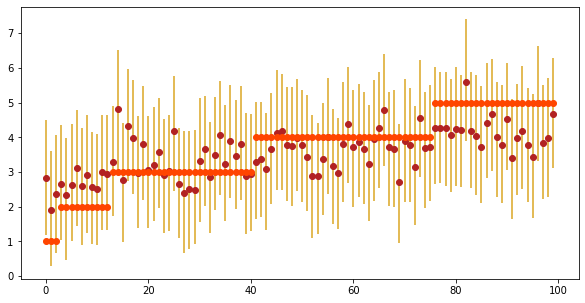

In [23]:
def ci_df(self, df):
    fig, ax = plt.subplots(figsize=(10,5))
    self.ci(row_inds=df.user_id, col_inds=df.item_id, plot=True, zorder=0, ax=ax, 
       c='firebrick', ecolor='goldenrod')
    ax.scatter(range(len(df)), df.rating, c='orangered', zorder=1)
    plt.show()

ci_df(df_hist['model'][0], df_train.sample(n=100).sort_values('rating'))

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Test Place

1 1


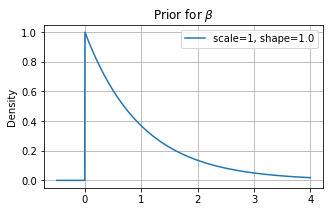

In [88]:
xrange = np.linspace(-0.5,4,1000)
a = 1
b = 1*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(xrange, y, label=f'scale={a}, shape={1/b}')
ax.legend()
ax.grid()
plt.title(r'Prior for $\beta$')
plt.ylabel('Density')
# plt.savefig('images/betaprior.pdf')
plt.show()

2 1.0


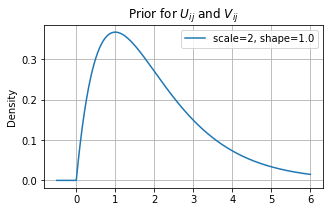

In [90]:
xrange = np.linspace(-0.5,6,1000)
a = 2
b = 0.5*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(xrange, y, label=f'scale={a}, shape={b}')
ax.legend()
ax.grid()
plt.title(r'Prior for $U_{ij}$ and $V_{ij}$')
plt.ylabel('Density')
# plt.savefig('images/nmfprior.pdf')
plt.show()

1 0.08


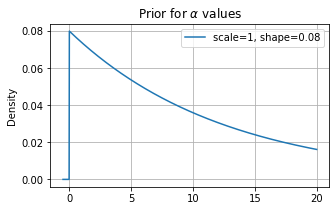

In [97]:
xrange = np.linspace(-0.5,20,1000)
a = 1
b = 0.08*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(xrange, y, label=f'scale={a}, shape={b}')
ax.legend()
ax.grid()
plt.title(r'Prior for $\alpha$ values')
plt.ylabel('Density')
plt.savefig('images/alphaprior.pdf')
plt.show()

1 1


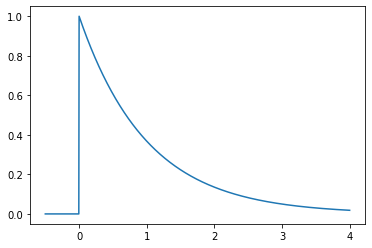

2 2


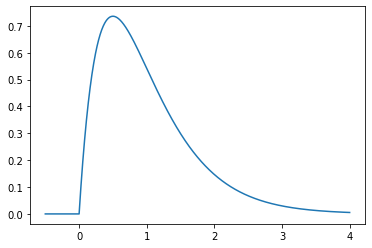

1 0.08


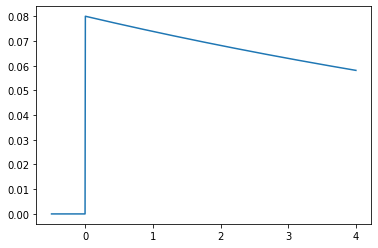

In [3]:
xrange = np.linspace(-0.5,4,1000)

a = 1
b = 1*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
plt.plot(xrange, y)
plt.show()

a = 2
b = 1*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
plt.plot(xrange, y)
plt.show()

a = 1
b = 0.08*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
plt.plot(xrange, y)
# plt.axvline(((a-1)/b/(a-1)))
plt.show()